# DIRAC Spatial Multi-Omics — Vertical Integration
> **Goal:** Integrate spatial **RNA**, **Protein (ADT)**, and **ATAC** with **DIRAC**, then cluster and visualize tissue structure. This guide walks through data loading, preprocessing, graph construction, integration, clustering, visualization, and evaluation.

---

## Table of Contents

1. [Environment & Data](#environment--data)  
2. [Load Packages](#load-packages)  
3. [Load Modalities](#load-modalities)  
4. [Preprocess](#preprocess)  
5. [Build the Spatial Graph](#build-the-spatial-graph)  
6. [Two-Omics Integration (RNA + ADT)](#two-omics-integration-rna--adt)  
7. [Clustering & Evaluate (ARI) & Visualization](#clustering--visualization)
8. [Auto-select resolution by maximizing the Calinski–Harabasz score](#auto-select-resolution)
9. [Extend to Three Omics (add ATAC)](#extend-to-three-omics-add-atac)  
10. [Subgraph Training (Optional)](#subgraph-training-optional)  
11. [Tips & Troubleshooting](#tips--troubleshooting)

---
<a id="environment--data"></a>
## 1）Environment & Data

**Dependencies**

- Python ≥ 3.8  
- `scanpy`, `anndata`, `numpy`, `matplotlib`, `scikit-learn`  
-  **DIRAC** codebase locally available (added to `sys.path`). If not installed, follow the official guide: [Install DIRAC](https://dirac-tutorial.readthedocs.io/en/latest/install.html)  

### Download NSF Data

**Source (three modalities):**
- **RNA** (gene expression)
- **ADT / Protein**
- **ATAC** (chromatin accessibility)

**Download link:**  
- https://drive.google.com/drive/folders/1Q9xVtwlDiUgdCy9BR4BzeR0_9Zlr5asW?usp=drive_link

---
<a id="load-packages"></a>
## 2）Load Packages

In [1]:
import os
import scanpy as sc
import numpy as np
import sys
import matplotlib.pyplot as plt
import anndata
from sklearn.metrics.cluster import adjusted_rand_score

sys.path.append("../DIRAC-main")
import sodirac_test as sd
sd.utils.seed_torch(seed=0)

data_path = "../DIRAC-main/data/NSF"
save_path = './Results'
methods = "DIRAC"
n_clusters = 5

---
<a id="load-modalities"></a>
## 3）Load Modalities
Read the AnnData objects for RNA and ADT (and later ATAC).

**Assumptions**
- adata.obsm["spatial"] contains spatial coordinates.
- adata.obs["ground_truth"] provides labels for evaluation (simulated dataset).

In [2]:
adata_RNA = anndata.read_h5ad(os.path.join(data_path, "sim_RNA.h5ad"))
adata_Protein = anndata.read_h5ad(os.path.join(data_path, "sim_ADT.h5ad"))
print(adata_RNA);print(adata_Protein)

AnnData object with n_obs × n_vars = 4096 × 2000
    obs: 'ground_truth'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 4096 × 100
    obs: 'ground_truth'
    obsm: 'spatial'


---
<a id="preprocess"></a>
## 4) Preprocess
(Standard normalization/log-transform/scale for RNA & ADT; PCA for RNA.)

**Why these steps?**

- Makes modalities comparable and denoised before graph-based integration.
- PCA yields a compact representation for RNA to feed into the GNN.

In [3]:
sc.pp.filter_genes(adata_RNA, min_cells=3)
sc.pp.normalize_total(adata_RNA)
sc.pp.log1p(adata_RNA)
sc.pp.scale(adata_RNA)
sc.tl.pca(adata_RNA, n_comps=50)

sc.pp.normalize_total(adata_Protein)
sc.pp.log1p(adata_Protein)
sc.pp.scale(adata_Protein)

---
<a id="build-the-spatial-graph"></a>
## 5) Build the Spatial Graph

(Construct a graph over spatial coordinates. Start with k-NN; use radius when platform resolution requires explicit distance control.)

    # Option A: k-NN (recommended starting point)
    edge_index = sd.utils.get_single_edge_index(
        adata_RNA.obsm["spatial"],
        n_neighbors=8,
        graph_methods="knn"
    )

    # Option B: radius (tune n_radius to match platform resolution)
    edge_index = sd.utils.get_single_edge_index(
        adata_RNA.obsm["spatial"],
        n_radius=0.1,
        graph_methods="radius"
    )

**Note**

- Different spatial platforms have different spot sizes/resolutions; for radius graphs, tune n_radius until neighborhoods look reasonable.

In [4]:
edge_index = sd.utils.get_single_edge_index(adata_RNA.obsm["spatial"], n_neighbors = 8, graph_methods='knn')

Average neighbors per node (directed): 8.00 (edges=32768, nodes=4096)


---
<a id="two-omics-integration-rna--adt"></a>
## 6) Two-Omics Integration (RNA + ADT)

In [5]:
dirac = sd.main.integrate_app(save_path = save_path, use_gpu = True, subgraph = False)
samples = dirac._get_data(dataset_list = [adata_RNA.obsm['X_pca'], adata_Protein.X], edge_index = edge_index)
models = dirac._get_model(samples)
data_z, combine_recon = dirac._train_dirac_integrate(samples = samples, models = models, epochs = 200)
adata_RNA.obsm["DIRAC_embed"] = combine_recon
adata_Protein.obsm["DIRAC_embed"] = combine_recon

Found 2 unique domains.


DIRAC integrate..: 100%|█| 200/200 [0


---
<a id="clustering--visualization"></a>
## 7) Clustering & Compute ARI & Visualization
(Use Leiden or MCLUST; below shows mclust in 9))

    # Option B: Mclust (requires R + mclust)
    sd.utils.mclust_R(adata_RNA, num_cluster=n_clusters)

**Interpretation**

- ARI ≈ 1.0 → perfect match
- ARI ≈ 0 → random alignment
- ARI < 0 → worse than random

Best resolution:  0.02


<Axes: title={'center': 'DIRAC (ARI:0.9935707694496735)'}, xlabel='spatial1', ylabel='spatial2'>

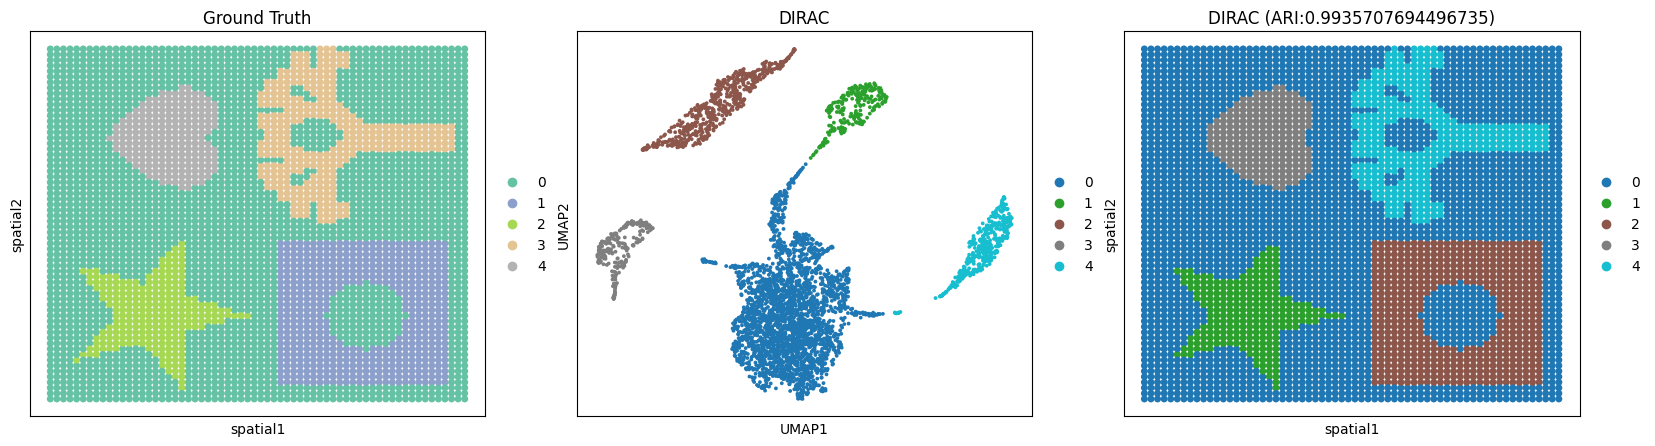

In [6]:
sc.pp.neighbors(adata_RNA, use_rep="DIRAC_embed", n_neighbors=15)
res = sd.utils._priori_cluster(adata_RNA, eval_cluster_n = n_clusters)
sc.tl.leiden(adata_RNA, resolution = res, key_added="DIRAC", flavor="igraph", n_iterations=2, directed=False)
sc.tl.umap(adata_RNA)
ARI = float(adjusted_rand_score(adata_RNA.obs['DIRAC'], adata_RNA.obs['ground_truth']))

fig, ax_list = plt.subplots(1, 3, figsize=(20, 5))
sc.pl.embedding(adata_RNA, basis='spatial', color='ground_truth', title='Ground Truth', s=100, show=False, palette="Set2", ax=ax_list[0])
sc.pl.umap(adata_RNA, color='DIRAC', title='DIRAC', s=30, show=False, palette="tab10", ax=ax_list[1])
sc.pl.embedding(adata_RNA, basis='spatial', color='DIRAC', title=f'DIRAC (ARI:{ARI})', s=100, show=False, palette="tab10", ax=ax_list[2])

---
<a id="auto-select-resolution"></a>
## 8) Auto-select resolution by maximizing the Calinski–Harabasz score

**How it works:**
- Prior-free: Users do not provide n_clusters; only the data are required.
- Resolution sweep: Run Leiden across a grid of resolutions (e.g., 0.01–2.5, step 0.01).
- Internal validity: For each partition, compute the Calinski–Harabasz score, which balances within-cluster compactness and between-cluster separation.
- Model selection: Pick the resolution with the highest CH score; this implicitly fixes the number of spatial niches (clusters).

Best resolution:  0.01


<Axes: title={'center': 'DIRAC (ARI:0.9935707694496735)'}, xlabel='spatial1', ylabel='spatial2'>

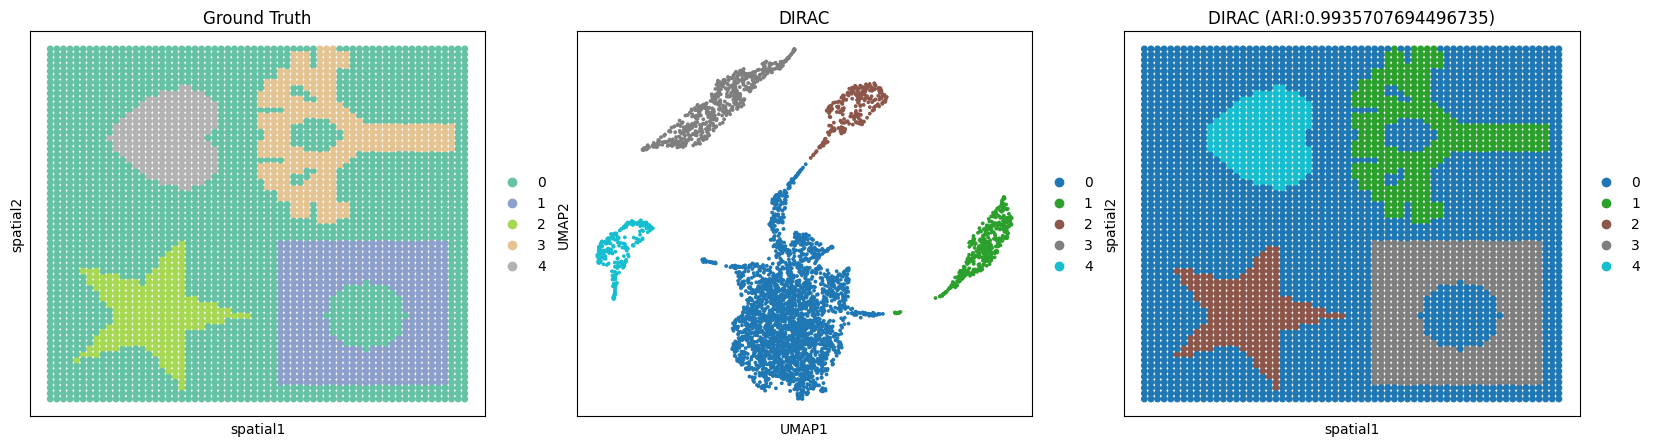

In [7]:
res = sd.utils._optimize_cluster(adata_RNA)
sc.tl.leiden(adata_RNA, resolution = res, key_added="DIRAC", flavor="igraph", n_iterations=2, directed=False)
sc.tl.umap(adata_RNA)
ARI = float(adjusted_rand_score(adata_RNA.obs['DIRAC'], adata_RNA.obs['ground_truth']))

fig, ax_list = plt.subplots(1, 3, figsize=(20, 5))
sc.pl.embedding(adata_RNA, basis='spatial', color='ground_truth', title='Ground Truth', s=100, show=False, palette="Set2", ax=ax_list[0])
sc.pl.umap(adata_RNA, color='DIRAC', title='DIRAC', s=30, show=False, palette="tab10", ax=ax_list[1])
sc.pl.embedding(adata_RNA, basis='spatial', color='DIRAC', title=f'DIRAC (ARI:{ARI})', s=100, show=False, palette="tab10", ax=ax_list[2])

---
<a id="extend-to-three-omics-add-atac"></a>
## 9) Extend to Three Omics (add ATAC)

AnnData object with n_obs × n_vars = 4096 × 4000
    obs: 'ground_truth'
    obsm: 'spatial'
Found 3 unique domains.


DIRAC integrate..: 100%|█| 200/200 [0
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


<Axes: title={'center': 'DIRAC (ARI:0.994213907242581)'}, xlabel='spatial1', ylabel='spatial2'>

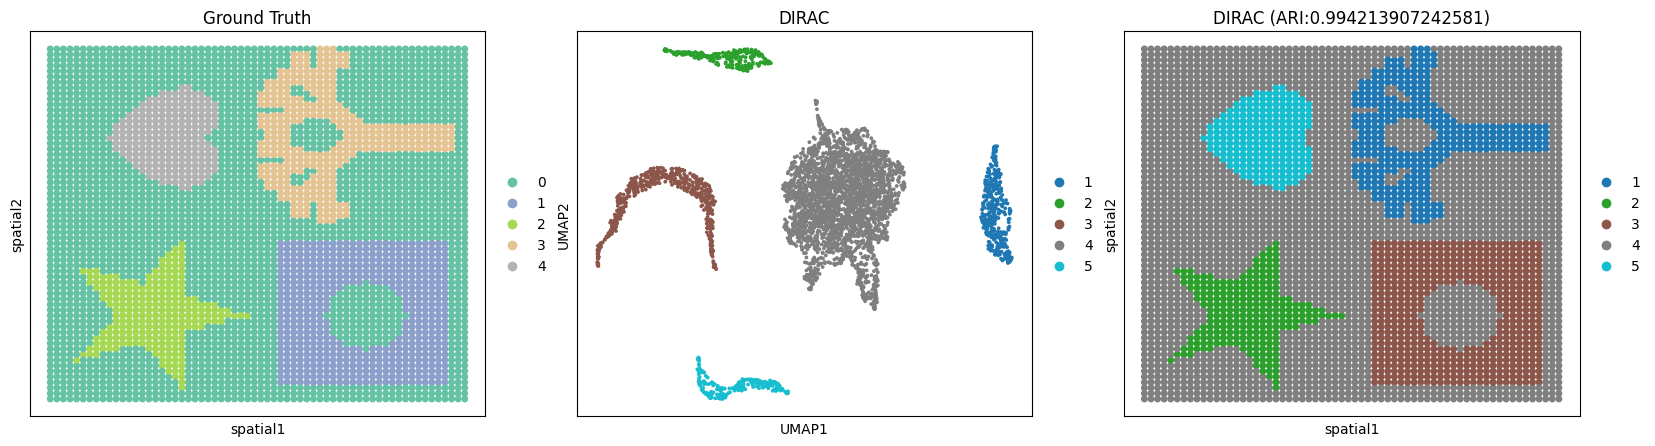

In [8]:
adata_ATAC = anndata.read_h5ad(os.path.join(data_path, "sim_ATAC.h5ad"))
print(adata_ATAC)

sc.pp.filter_genes(adata_ATAC, min_cells=3)
sd.utils.lsi(adata_ATAC, n_comps=100)

dirac = sd.main.integrate_app(save_path = save_path, use_gpu = True, subgraph = False)
samples = dirac._get_data(dataset_list = [adata_RNA.obsm['X_pca'], adata_Protein.X, adata_ATAC.obsm['X_lsi']], edge_index = edge_index)
models = dirac._get_model(samples,opt_GNN = "GAT")
data_z, combine_recon  = dirac._train_dirac_integrate(samples = samples,models = models,epochs = 200)

adata_RNA.obsm["DIRAC_embed"] = combine_recon
sc.pp.neighbors(adata_RNA, use_rep="DIRAC_embed")
sd.utils.mclust_R(adata_RNA, num_cluster=n_clusters, used_obsm="DIRAC_embed", key_added="DIRAC")
sc.tl.umap(adata_RNA)
ARI = float(adjusted_rand_score(adata_RNA.obs['DIRAC'], adata_RNA.obs['ground_truth']))

fig, ax_list = plt.subplots(1, 3, figsize=(20, 5))
sc.pl.embedding(adata_RNA, basis='spatial', color='ground_truth', title='Ground Truth', s=100, show=False, palette="Set2", ax=ax_list[0])
sc.pl.umap(adata_RNA, color='DIRAC', title='DIRAC', s=30, show=False, palette="tab10", ax=ax_list[1])
sc.pl.embedding(adata_RNA, basis='spatial', color='DIRAC', title=f'DIRAC (ARI:{ARI})', s=100, show=False, palette="tab10", ax=ax_list[2])

---
<a id="subgraph-training-optional"></a>
## 10) Subgraph Training (Optional)
(Enable subgraph=True for large tissues or memory constraints.)
- Key idea: turn on subgraph mode at app creation, and set `num_parts` in `_get_data` to control how many subgraphs you split into.

**When to use**

- Very large graphs
- Limited GPU RAM

Computing METIS partitioning...
Done!


Found 3 unique domains.


DIRAC integrate..: 100%|█| 200/200 [0


fitting ...
  |======================================================================| 100%


<Axes: title={'center': 'DIRAC (ARI:0.9957281504554227)'}, xlabel='spatial1', ylabel='spatial2'>

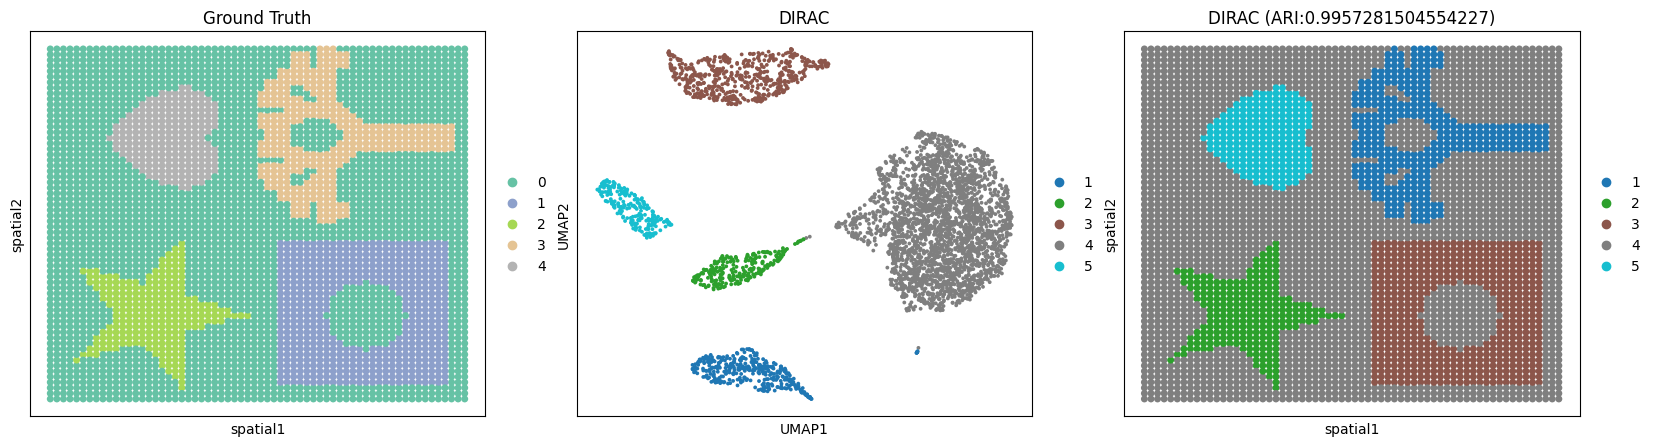

In [9]:
dirac = sd.main.integrate_app(save_path = save_path, use_gpu = True, subgraph = True)
samples = dirac._get_data(dataset_list = [adata_RNA.obsm['X_pca'], adata_Protein.X, adata_ATAC.obsm['X_lsi']],\
                          edge_index = edge_index, num_parts = 5)
models = dirac._get_model(samples, opt_GNN = "GAT")
data_z, combine_recon  = dirac._train_dirac_integrate(samples = samples, models = models, epochs = 200)

adata_RNA.obsm["DIRAC_embed"] = combine_recon
sc.pp.neighbors(adata_RNA, use_rep="DIRAC_embed")
sd.utils.mclust_R(adata_RNA, num_cluster=n_clusters, used_obsm="DIRAC_embed", key_added="DIRAC")
sc.tl.umap(adata_RNA)
ARI = float(adjusted_rand_score(adata_RNA.obs['DIRAC'], adata_RNA.obs['ground_truth']))

fig, ax_list = plt.subplots(1, 3, figsize=(20, 5))
sc.pl.embedding(adata_RNA, basis='spatial', color='ground_truth', title='Ground Truth', s=100, show=False, palette="Set2", ax=ax_list[0])
sc.pl.umap(adata_RNA, color='DIRAC', title='DIRAC', s=30, show=False, palette="tab10", ax=ax_list[1])
sc.pl.embedding(adata_RNA, basis='spatial', color='DIRAC', title=f'DIRAC (ARI:{ARI})', s=100, show=False, palette="tab10", ax=ax_list[2])

---
<a id="tips--troubleshooting"></a>
## 11) Tips & Troubleshooting

- DIRAC install: If DIRAC is not installed, follow → https://dirac-tutorial.readthedocs.io/en/latest/install.html
- GPU vs CPU: Set use_gpu=True if CUDA is available; otherwise False (training will be slower).
- Graph choice: Start with k-NN; consider radius when platform spot sizes demand explicit distance thresholds (tune n_radius).
- Mclust: Requires R with mclust on PATH; if not available, use Leiden.
- Scaling & LSI: Keep RNA/ADT standardized; use LSI for ATAC.
- Reproducibility: Seeds help, but GPU nondeterminism (cuDNN) may still cause minor drifts.
- Memory: Reduce n_hiddens/n_outputs, enable subgraph=True, or decrease neighborhood sizes if you hit OOM.